Class Distribution:
 HeartFailure
1    508
0    410
Name: count, dtype: int64


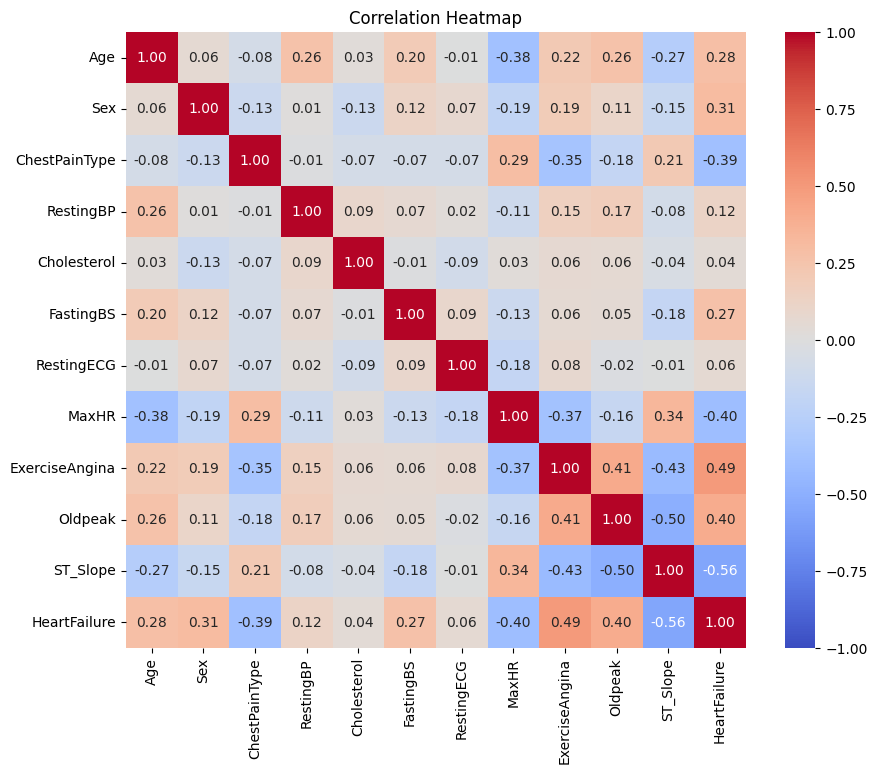

<ipython-input-2-742c80a564c9>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="HeartFailure", data=data, palette="pastel")


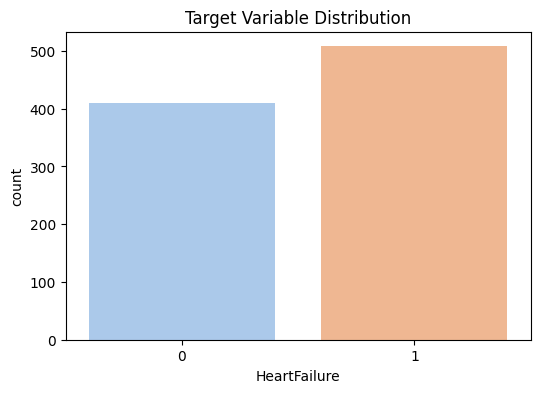

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Model: Random Forest

Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        77
           1       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184


Confusion Matrix:
[[68  9]
 [19 88]]

ROC AUC: 0.9030
Accuracy: 0.8478

Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        77
           1       0.91      0.86      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184


Confusion Matrix:
[[68  9]
 [15 92]]

ROC AUC: 0.9367
Accuracy: 0.8696

Model: XGBoost

Classification Report:
              precision    recall  f1-

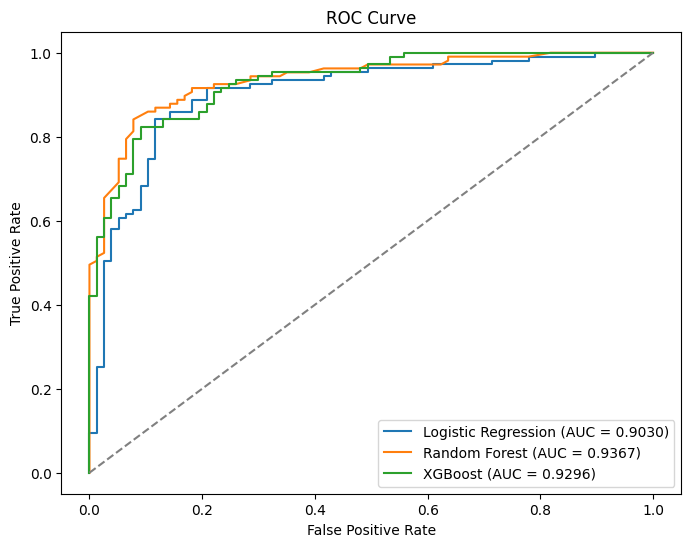

Prediction for sample input (1 = Heart Failure, 0 = No Heart Failure): [1]
The person is likely to have heart failure.
Prediction Probabilities (0: No Heart Failure, 1: Heart Failure): [[0.43 0.57]]


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)

# Load the dataset
file_path = '/content/heart.csv'
data = pd.read_csv(file_path)

# Data Preprocessing
# Replace 0 in RestingBP and Cholesterol with median values (assuming 0 is an anomaly)
data["RestingBP"] = data["RestingBP"].replace(0, data["RestingBP"].median())
data["Cholesterol"] = data["Cholesterol"].replace(0, data["Cholesterol"].median())

# Encode categorical features
categorical_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    data[col] = label_encoders[col].fit_transform(data[col])

# Splitting data into training and testing sets
X = data.drop("HeartFailure", axis=1)
y = data["HeartFailure"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler AFTER train-test split
numerical_columns = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Check class distribution
print("Class Distribution:\n", y.value_counts())

# Exploratory Data Analysis (EDA)
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="HeartFailure", data=data, palette="pastel")
plt.title("Target Variable Distribution")
plt.show()

# Model Training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
}

model_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    model_results[name] = {
        "Classification Report": classification_report(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "ROC AUC": auc,
        "Accuracy": accuracy,
    }

# Evaluation
best_model_name = max(model_results, key=lambda x: model_results[x]['Accuracy'])
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}\n")

for name, results in model_results.items():
    print(f"Model: {name}\n")
    print(f"Classification Report:\n{results['Classification Report']}\n")
    print(f"Confusion Matrix:\n{results['Confusion Matrix']}\n")
    print(f"ROC AUC: {results['ROC AUC']:.4f}")
    print(f"Accuracy: {results['Accuracy']:.4f}\n")

# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {model_results[name]['ROC AUC']:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Dynamically create sample_input to match X_train's column order
sample_data = {
    "Age": [60],
    "RestingBP": [140],
    "Cholesterol": [200],
    "MaxHR": [150],
    "Oldpeak": [1.0],
    "Sex": [1],
    "ChestPainType": [3],
    "RestingECG": [0],
    "ExerciseAngina": [1],
    "ST_Slope": [2],
    "FastingBS": [0],  # Ensure binary feature
}

sample_input = pd.DataFrame(sample_data)

# Ensure the column order matches X_train
sample_input = sample_input[X_train.columns]

# Scale numerical features in the sample input
sample_input[numerical_columns] = scaler.transform(sample_input[numerical_columns])

# Make a prediction using the best model
prediction = best_model.predict(sample_input)
prediction_proba = best_model.predict_proba(sample_input)

# Print results
print("Prediction for sample input (1 = Heart Failure, 0 = No Heart Failure):", prediction)
if prediction == 1:
    print("The person is likely to have heart failure.")
else:
    print("The person is unlikely to have heart failure.")

print("Prediction Probabilities (0: No Heart Failure, 1: Heart Failure):", prediction_proba)